Valid samples: 500


C:\Users\CLEMENTENA J\AppData\Local\Temp\ipykernel_14164\2310962345.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, labels = x.to(device), torch.tensor(labels).to(device)
C:\Users\CLEMENTENA J\AppData\Local\Temp\ipykernel_14164\2310962345.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, labels = x.to(device), torch.tensor(labels).to(device)


Epoch 1: Train Acc=0.60, Val Acc=0.35
Epoch 2: Train Acc=0.59, Val Acc=0.74
Epoch 3: Train Acc=0.60, Val Acc=0.85
Epoch 4: Train Acc=0.67, Val Acc=0.95
Epoch 5: Train Acc=0.64, Val Acc=0.77
Epoch 6: Train Acc=0.64, Val Acc=0.66
Epoch 7: Train Acc=0.61, Val Acc=0.59
Epoch 8: Train Acc=0.66, Val Acc=0.97
Epoch 9: Train Acc=0.77, Val Acc=0.83
Epoch 10: Train Acc=0.81, Val Acc=0.84
Epoch 11: Train Acc=0.72, Val Acc=0.93
Epoch 12: Train Acc=0.61, Val Acc=0.98
Epoch 13: Train Acc=0.74, Val Acc=0.99
Epoch 14: Train Acc=0.70, Val Acc=0.98
Epoch 15: Train Acc=0.69, Val Acc=0.84
Epoch 16: Train Acc=0.72, Val Acc=0.96
Epoch 17: Train Acc=0.66, Val Acc=0.98
Epoch 18: Train Acc=0.71, Val Acc=0.98
Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.97      0.97        40
           2       0.95      0.95      0.95        20

    accuracy                           

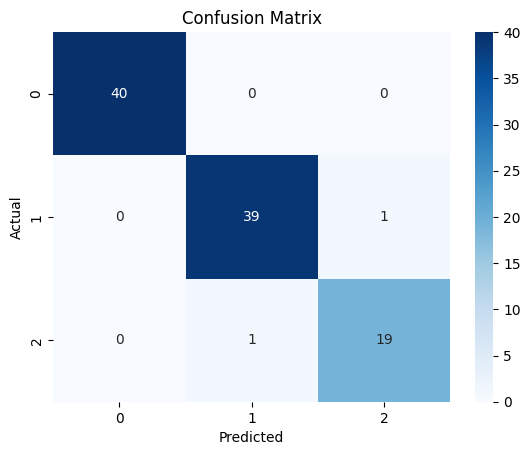

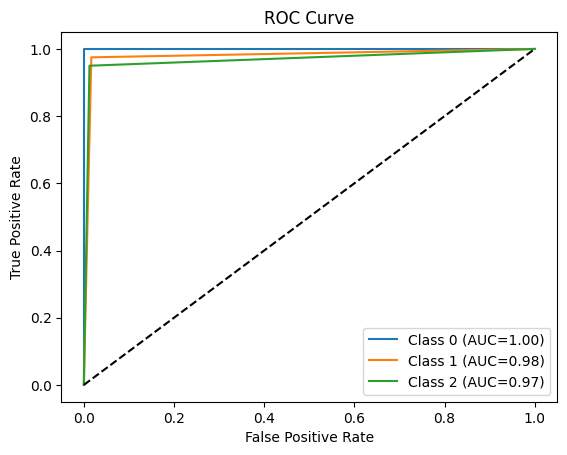

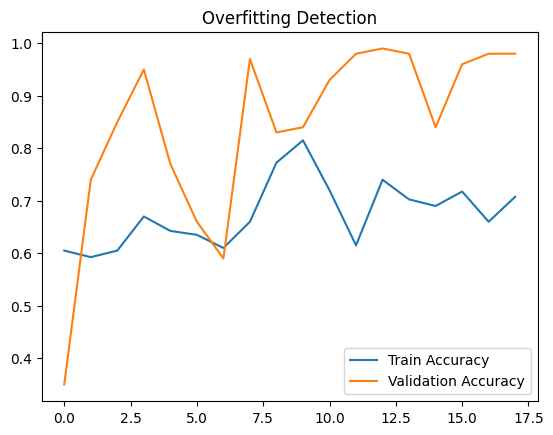

In [ ]:
# ====================== Existing Imports ======================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet18
import seaborn as sns
import random

# ====================== Load and preprocess data ======================
def load_dataset(file_path, label):
    df = pd.read_excel(file_path)
    samples, labels = [], []
    for row in df['Content']:
        try:
            values = [float(i) for i in row.replace('\n', '-').split('-') if i.strip() != '']
            samples.append(values)
            labels.append(label)
        except:
            continue
    return samples, labels

X1, y1 = load_dataset("normal_data.xlsx", 0)
X2, y2 = load_dataset("epilepsy_without_seizure_data.xlsx", 1)
X3, y3 = load_dataset("epilepsy_with_seizure_data.xlsx", 2)

X = X1 + X2 + X3
y = y1 + y2 + y3

# ====================== EEG Dataset ======================
class EEGDataset(Dataset):
    def __init__(self, signals, labels):
        self.data = []
        self.labels = []
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=100, n_fft=64, hop_length=16, n_mels=32
        )

        for signal, label in zip(signals, labels):
            waveform = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
            try:
                spec = self.mel_spec(waveform)
                spec = torch.log2(spec + 1e-9)
                if spec.isnan().any() or spec.max() == 0:
                    continue
                self.data.append(spec)
                self.labels.append(label)
            except:
                continue

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = EEGDataset(X, y)
print("Valid samples:", len(dataset))

# ====================== Stratified Train-Val Split ======================
def stratified_split(dataset, labels, split_ratio=0.8):
    labels = np.array(labels)
    skf = StratifiedKFold(n_splits=int(1 / (1 - split_ratio)))
    train_idx, val_idx = next(skf.split(np.zeros(len(labels)), labels))
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

train_dataset, val_dataset = stratified_split(dataset, dataset.labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# ====================== Mixup Augmentation ======================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ====================== Label Smoothing ======================
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        pred = x.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# ====================== Model ======================
class ResNet18EEG(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = resnet18(weights=None)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# ====================== Train Model ======================
def train_model():
    model = ResNet18EEG()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = LabelSmoothingLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_acc = 0
    patience = 5
    wait = 0

    train_accs, val_accs = [], []

    for epoch in range(30):
        model.train()
        correct, total = 0, 0
        for x, labels in train_loader:
            x, labels = x.to(device), torch.tensor(labels).to(device)
            x, y_a, y_b, lam = mixup_data(x, labels)
            optimizer.zero_grad()
            out = model(x)
            loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, labels in val_loader:
                x, labels = x.to(device), torch.tensor(labels).to(device)
                out = model(x)
                preds = out.argmax(1)
                all_preds.extend(preds.cpu())
                all_labels.extend(labels.cpu())
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_eeg_model1.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    # Load best model
    model.load_state_dict(torch.load("best_eeg_model1.pth"))

    # Final Evaluation
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    y_true = label_binarize(all_labels, classes=[0, 1, 2])
    y_score = label_binarize(all_preds, classes=[0, 1, 2])
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Overfitting Check
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.legend()
    plt.title("Overfitting Detection")
    plt.show()

# ====================== Run Training ======================
train_model()

In [ ]:
import numpy as np

# Load the file
y_val = np.load("y_val2.npy", allow_pickle=True)

# Print the contents
print("Actual y_val labels:")
print(y_val)


Actual y_val labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

# ========== Load x_val ==========
x_val = np.load("x_val2.npy", allow_pickle=True)

# ========== Create Dataset ==========
class EEGValDataset(Dataset):
    def __init__(self, x):
        self.data = [torch.tensor(i, dtype=torch.float32) for i in x]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

val_dataset = EEGValDataset(x_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# ========== Define the Model ==========
class ResNet18EEG(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = resnet18(weights=None)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# ========== Load Trained Model ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18EEG()
model.load_state_dict(torch.load("best_eeg_model1.pth", map_location=device))
model.to(device)
model.eval()

# ========== Predict Only Using x_val ==========
predicted_labels = []

with torch.no_grad():
    for x in val_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)
        predicted_labels.extend(preds.cpu().numpy())

# ========== Output ==========
print("Predicted labels for x_val:")
print(predicted_labels)


Predicted labels for x_val:
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(

In [ ]:
predicted_labels = np.array(predicted_labels)  # Just in case it's a list
predicted_labels_list = predicted_labels.tolist()  # Convert to regular Python list
print("Predicted labels for x_val:")
print(predicted_labels_list)

Predicted labels for x_val:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Actual labels
y_val = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Predicted labels
predicted_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                             1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2])

# Count mismatches
mismatches = np.sum(y_val != predicted_labels)
accuracy = np.mean(y_val == predicted_labels) * 100

print(f"Total samples: {len(y_val)}")
print(f"Wrong predictions: {mismatches}")
print(f"Accuracy: {accuracy:.2f}%")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, predicted_labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, predicted_labels, digits=3))


Total samples: 100
Wrong predictions: 2
Accuracy: 98.00%

Confusion Matrix:
[[40  0  0]
 [ 0 39  1]
 [ 0  1 19]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        40
           1      0.975     0.975     0.975        40
           2      0.950     0.950     0.950        20

    accuracy                          0.980       100
   macro avg      0.975     0.975     0.975       100
weighted avg      0.980     0.980     0.980       100

